While playing with this dataset, I realised how hard it is to visualise pre-processed EEG data. I created this Jupyter notebook to document and share how I solved task of visualising this kind of data.  
I based my work on [mne](https://mne.tools/stable/index.html) library.

## Import libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from math import ceil

## Electrode positions

First, we needed to get positions of electrodes. You can use [mne.channels.make_standard_montage](https://mne.tools/stable/generated/mne.channels.make_standard_montage.html?highlight=mne+channels+make_standard_montage#mne.channels.make_standard_montage) but I had data with 19 electrodes, like in this image:

![10/20 mount](https://www.researchgate.net/profile/Danny-Plass-Oude-Bos/publication/237777779/figure/fig3/AS:669556259434497@1536646060035/10-20-system-of-electrode-placement.png)

So I created my own positions:

In [21]:
chs = {'FP1': [-0.03, 0.08],
       'FP2': [0.03, 0.08],
       'F7': [-0.073, 0.047],
       'F3': [-0.04, 0.041],
       'Fz': [0, 0.038],
       'F4': [0.04, 0.041],
       'F8': [0.073, 0.047],
       'T3': [-0.085, 0],
       'C3': [-0.045, 0],
       'Cz': [0, 0],
       'C4': [0.045, 0],
       'T4': [0.085, 0],
       'T5': [-0.073, -0.047],
       'P3': [-0.04, -0.041],
       'Pz': [0, -0.038],
       'P4': [0.04, -0.041],
       'T6': [0.07, -0.047],
       'O1': [-0.03, -0.08],
       'O2': [0.03, -0.08]}
channels = pd.DataFrame(chs).transpose()
channels

,0,1
FP1,-0.030,0.080
FP2,0.030,0.080
F7,-0.073,0.047
F3,-0.040,0.041
Fz,0.000,0.038
F4,0.040,0.041
F8,0.073,0.047
T3,-0.085,0.000
C3,-0.045,0.000
Cz,0.000,0.000


This is how it looks:

In [22]:
# make_dig_montage accepts only 3D coordinates
for key in chs.keys():
    chs[key]+=[0]
chs

{'FP1': [-0.03, 0.08, 0],
 'FP2': [0.03, 0.08, 0],
 'F7': [-0.073, 0.047, 0],
 'F3': [-0.04, 0.041, 0],
 'Fz': [0, 0.038, 0],
 'F4': [0.04, 0.041, 0],
 'F8': [0.073, 0.047, 0],
 'T3': [-0.085, 0, 0],
 'C3': [-0.045, 0, 0],
 'Cz': [0, 0, 0],
 'C4': [0.045, 0, 0],
 'T4': [0.085, 0, 0],
 'T5': [-0.073, -0.047, 0],
 'P3': [-0.04, -0.041, 0],
 'Pz': [0, -0.038, 0],
 'P4': [0.04, -0.041, 0],
 'T6': [0.07, -0.047, 0],
 'O1': [-0.03, -0.08, 0],
 'O2': [0.03, -0.08, 0]}

/tmp/ipykernel_17/2461572216.py:2: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mont.plot()


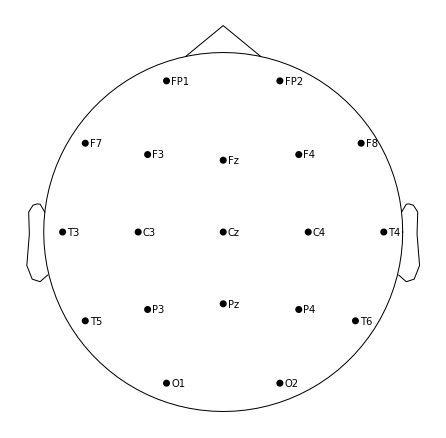

In [23]:
mont = mne.channels.make_dig_montage(chs)
mont.plot()
plt.show()

## Visualisation function
Here is the crux of this notebook, the functions I wrote to visulize data:

In [24]:
def plot_eeg(levels, positions, axes, fig, ch_names=None, cmap='Spectral_r', cb_pos=(0.9, 0.1),
             cb_width=0.04, cb_height=0.9, marker=None, marker_style=None, vmin=None, vmax=None, **kwargs):
    """
    Function visulises processed EEG data in a simple way. Based on mne.viz.plot_topomap.


    :param levels: numpy.array, shape (n_chan,)
        data values to plot.
    :param positions: numpy.array, shape (n_chan, 2)|instance of mne.Info
        Location information for the data points(/channels). If an array, for each data point,
        the x and y coordinates. If an Info object, it must contain only one data type and exactly
        len(data) data channels, and the x/y coordinates will be inferred from the montage applied
        to the Info object.
    :param axes: matplotlib.axes.Axes
        The axes to plot to.
    :param fig: matplotlib.figure.Figure
        The figure to create colorbar on.
    :param ch_names: list | None
        List of channel names. If None, channel names are not plotted.
    :param cmap: matplotlib colormap | None
        Colormap to use. If None, ‘Reds’ is used for all positive data, otherwise defaults to ‘RdBu_r’.
        Default value is 'Spectral_r'
    :param cb_pos: tuple/list of floats
        Coordinates of color bar
    :param cb_width: float
        Width of colorbar
    :param cb_height: float
        Height of colorbar
    :param marker: numpy.array of bool, shape (n_channels,) | None
        Array indicating channel(s) to highlight with a distinct plotting style.
        Array elements set to True will be plotted with the parameters given in mask_params.
        Defaults to None, equivalent to an array of all False elements.
    :param marker_style: dict | None
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='w', markeredgecolor='k', linewidth=0, markersize=4)
    :param vmin, vmax: float | callable() | None
        Lower and upper bounds of the colormap, in the same units as the data.
        If vmin and vmax are both None, they are set at ± the maximum absolute value
        of the data (yielding a colormap with midpoint at 0). If only one of vmin, vmax is None,
        will use min(data) or max(data), respectively. If callable, should accept a NumPy array
        of data and return a float.
    :param kwargs:
        any other parameter used in mne.viz.plot_topomap
    :return im: matplotlib.image.AxesImage
        The interpolated data.
    :return cn: matplotlib.contour.ContourSet
        The fieldlines.
    """
    if 'mask' not in kwargs:
        mask = np.ones(levels.shape[0], dtype='bool')
    else:
        mask = None
    im, cm = mne.viz.plot_topomap(levels, positions, axes=axes, names=ch_names, vmin=vmin, vmax=vmax,
                          cmap=cmap, mask=mask, mask_params=marker_style, show=False, **kwargs)

    cbar_ax = fig.add_axes([cb_pos[0], cb_pos[1], cb_width, cb_height])
    clb = axes.figure.colorbar(im, cax=cbar_ax)
    return im, cm

## Read data

In [25]:
df = pd.read_csv('../input/eeg-psychiatric-disorders-dataset/EEG.machinelearing_data_BRMH.csv')
df

,no.,sex,age,eeg.date,education,IQ,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,...,COH.F.gamma.o.Pz.p.P4,COH.F.gamma.o.Pz.q.T6,COH.F.gamma.o.Pz.r.O1,COH.F.gamma.o.Pz.s.O2,COH.F.gamma.p.P4.q.T6,COH.F.gamma.p.P4.r.O1,COH.F.gamma.p.P4.s.O2,COH.F.gamma.q.T6.r.O1,COH.F.gamma.q.T6.s.O2,COH.F.gamma.r.O1.s.O2
0,1,M,57.0,2012.8.30,NaN,NaN,Addictive disorder,Alcohol use disorder,35.998557,21.717375,...,55.989192,16.739679,23.452271,45.678820,30.167520,16.918761,48.850427,9.422630,34.507082,28.613029
1,2,M,37.0,2012.9.6,6.0,120.0,Addictive disorder,Alcohol use disorder,13.425118,11.002916,...,45.595619,17.510824,26.777368,28.201062,57.108861,32.375401,60.351749,13.900981,57.831848,43.463261
2,3,M,32.0,2012.9.10,16.0,113.0,Addictive disorder,Alcohol use disorder,29.941780,27.544684,...,99.475453,70.654171,39.131547,69.920996,71.063644,38.534505,69.908764,27.180532,64.803155,31.485799
3,4,M,35.0,2012.10.8,18.0,126.0,Addictive disorder,Alcohol use disorder,21.496226,21.846832,...,59.986561,63.822201,36.478254,47.117006,84.658376,24.724096,50.299349,35.319695,79.822944,41.141873
4,5,M,36.0,2012.10.18,16.0,112.0,Addictive disorder,Alcohol use disorder,37.775667,33.607679,...,61.462720,59.166097,51.465531,58.635415,80.685608,62.138436,75.888749,61.003944,87.455509,70.531662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,941,M,22.0,2014.8.28,13.0,116.0,Healthy control,Healthy control,41.851823,36.771496,...,82.905657,34.850706,63.970519,63.982003,51.244725,62.203684,62.062237,31.013031,31.183413,98.325230
941,942,M,26.0,2014.9.19,13.0,118.0,Healthy control,Healthy control,18.986856,19.401387,...,65.917918,66.700117,44.756285,49.787513,98.905995,54.021304,93.902401,52.740396,92.807331,56.320868
942,943,M,26.0,2014.9.27,16.0,113.0,Healthy control,Healthy control,28.781317,32.369230,...,61.040959,27.632209,45.552852,33.638817,46.690983,19.382928,41.050717,7.045821,41.962451,19.092111
943,944,M,24.0,2014.9.20,13.0,107.0,Healthy control,Healthy control,19.929100,25.196375,...,99.113664,48.328934,41.248470,28.192238,48.665743,42.007147,28.735945,27.176500,27.529522,20.028446


## Pre-process data for visualization
Even pre-processed data need some processing before visualisation

We need only main.disorder, specific.disorder and absolute power per band per channel (eg. AB.A.delta.a.FP1)

In [26]:
# One of the columns contains no data, it separates data
# patient info | abs power of PSD per band per channel | sep_col | functional connectivity data
mis = df.isna().sum()
sep_col = mis[mis == df.shape[0]].index[0]
df = df.loc[:, 'main.disorder':sep_col].drop(sep_col, axis=1)
df

,main.disorder,specific.disorder,AB.A.delta.a.FP1,AB.A.delta.b.FP2,AB.A.delta.c.F7,AB.A.delta.d.F3,AB.A.delta.e.Fz,AB.A.delta.f.F4,AB.A.delta.g.F8,AB.A.delta.h.T3,...,AB.F.gamma.j.Cz,AB.F.gamma.k.C4,AB.F.gamma.l.T4,AB.F.gamma.m.T5,AB.F.gamma.n.P3,AB.F.gamma.o.Pz,AB.F.gamma.p.P4,AB.F.gamma.q.T6,AB.F.gamma.r.O1,AB.F.gamma.s.O2
0,Addictive disorder,Alcohol use disorder,35.998557,21.717375,21.518280,26.825048,26.611516,25.732649,16.563408,29.891368,...,1.993727,1.765493,1.464281,1.501948,1.707307,1.553448,1.552658,1.388662,1.592717,1.806598
1,Addictive disorder,Alcohol use disorder,13.425118,11.002916,11.942516,15.272216,14.151570,12.456034,8.436832,9.975238,...,0.903383,0.931967,0.437117,0.930843,1.234874,1.373268,1.411808,1.140695,1.118041,3.162143
2,Addictive disorder,Alcohol use disorder,29.941780,27.544684,17.150159,23.608960,27.087811,13.541237,16.523963,12.775574,...,1.096713,1.691152,1.505663,1.133891,1.661768,1.403429,1.349457,1.270525,1.408471,1.454618
3,Addictive disorder,Alcohol use disorder,21.496226,21.846832,17.364316,13.833701,14.100954,13.100939,14.613650,8.063191,...,1.115040,1.122776,2.128138,1.648217,1.147666,1.049152,1.131654,1.415856,1.391048,1.527403
4,Addictive disorder,Alcohol use disorder,37.775667,33.607679,21.865556,21.771413,22.854536,21.456377,15.969042,9.434306,...,1.193191,2.320845,3.562820,1.441662,1.018804,1.274009,2.350806,2.307730,2.129431,3.766860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,Healthy control,Healthy control,41.851823,36.771496,43.671792,36.860889,24.732236,23.607823,23.288260,7.520642,...,1.966436,1.763397,1.285942,2.437923,2.130979,1.727413,1.710518,2.574734,2.533354,5.596057
941,Healthy control,Healthy control,18.986856,19.401387,27.586436,20.194732,19.407491,20.216570,16.465027,13.178851,...,2.701922,2.685138,2.648595,2.559590,3.054965,3.163359,3.247100,2.646515,3.385173,3.085049
942,Healthy control,Healthy control,28.781317,32.369230,11.717778,23.134370,26.209302,25.484497,22.586688,11.368466,...,3.258838,2.434620,1.501337,0.840513,1.733498,1.610465,1.644675,1.216763,1.614421,1.164097
943,Healthy control,Healthy control,19.929100,25.196375,14.445391,16.453456,16.590649,16.007279,18.909188,13.438102,...,1.849005,1.678465,3.655796,1.429330,3.151128,1.630643,1.888551,1.447402,1.819110,1.302056


I want columns to be in format: band.channel

In [27]:
def reformat_name(name):
    '''
    reformat from XX.X.band.x.channel to band.channel
    '''
    band, _, channel = name[5:].split(sep='.')
    return f'{band}.{channel}'
reformat_vect = np.vectorize(reformat_name)
new_colnames = np.concatenate((df.columns[:2],
                              reformat_vect(df.columns[2:])))
df.set_axis(new_colnames, axis=1, inplace=True)
df.columns

Index(['main.disorder', 'specific.disorder', 'delta.FP1', 'delta.FP2',
       'delta.F7', 'delta.F3', 'delta.Fz', 'delta.F4', 'delta.F8', 'delta.T3',
       ...
       'gamma.Cz', 'gamma.C4', 'gamma.T4', 'gamma.T5', 'gamma.P3', 'gamma.Pz',
       'gamma.P4', 'gamma.T6', 'gamma.O1', 'gamma.O2'],
      dtype='object', length=116)

Calculate mean powers per main.disorder and per specific.disorder and transform form wide to long format:

In [28]:
# mean powers per main disorder
main_mean = df.groupby('main.disorder').mean().reset_index()
# mean powers per main disorder
spec_mean = df.groupby('specific.disorder').mean().reset_index()
# list of bands
bands = ['delta', 'theta', 'alpha', 'beta', 'highbeta', 'gamma']
# convert from wide to long
main_mean = pd.wide_to_long(main_mean, bands, ['main.disorder'], 'channel', sep='.', suffix='\w+')
spec_mean = pd.wide_to_long(spec_mean, bands, ['specific.disorder'], 'channel', sep='.', suffix='\w+')
main_mean

,,delta,theta,alpha,beta,highbeta,gamma
main.disorder,channel,,,,,,
Addictive disorder,FP1,18.831516,13.836983,24.308169,10.588020,2.041568,2.418517
Anxiety disorder,FP1,20.212546,12.220164,20.542989,11.369194,2.362892,2.874982
Healthy control,FP1,18.383673,11.877841,21.024037,9.197048,2.055055,2.577345
Mood disorder,FP1,20.652163,13.594064,23.575915,12.357410,2.629678,3.292514
Obsessive compulsive disorder,FP1,18.261254,12.469764,24.380553,9.946188,2.199657,3.096013
...,...,...,...,...,...,...,...
Healthy control,O2,9.597102,7.218941,20.192476,10.277784,1.955759,2.990976
Mood disorder,O2,13.887099,9.051129,28.289462,13.643925,2.554539,3.615276
Obsessive compulsive disorder,O2,11.490165,9.438324,31.925618,11.461414,2.151135,3.304698


## Visualization
We came to the crux of this notebook, visualisations. First, I visualise just one case:

In [29]:
main_mean.loc['Schizophrenia', 'gamma']

channel
FP1    3.681332
FP2    3.840776
F7     3.586139
F3     3.380585
Fz     3.279946
F4     3.411508
F8     3.784580
T3     4.228335
C3     3.165926
Cz     3.080554
C4     3.041254
T4     3.387337
T5     2.435776
P3     2.736861
Pz     2.799705
P4     2.865227
T6     2.966232
O1     4.257993
O2     3.868594
Name: gamma, dtype: float64

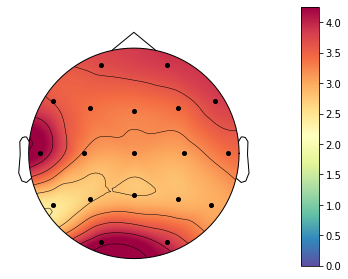

In [30]:
# extract power for one main.disorder and one band
test =  main_mean.loc['Schizophrenia', 'gamma']
# make sure that channels are in correct order
assert (test.index == channels.index).all()
# plot
fig, ax = plt.subplots()
plot_eeg(test, channels.to_numpy(), ax, fig, vmin=0, marker_style={'markersize':4, 'markerfacecolor':'black'})
plt.show()

Now, a more complex visualisation:

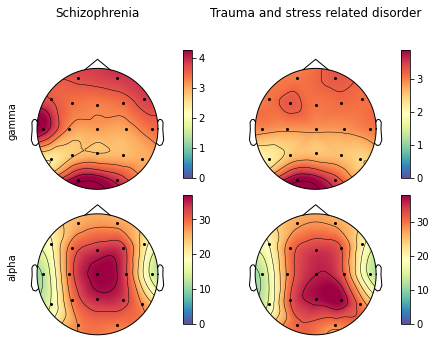

In [31]:
fig = plt.figure(constrained_layout=True, figsize=(6, 4))
test2 = [
     main_mean.loc['Schizophrenia', 'gamma'],
     main_mean.loc['Trauma and stress related disorder', 'gamma'],
     main_mean.loc['Schizophrenia', 'alpha'],
     main_mean.loc['Trauma and stress related disorder', 'alpha'],
]
subfigs = fig.subfigures(2,2)
for subfig, test1 in zip(subfigs.flatten(), test2):
    ax = subfig.subplots()
    plot_eeg(test1, channels.to_numpy(), ax, subfig, vmin=0, marker_style={'markersize':2, 'markerfacecolor':'black'})
subfigs[0, 0].suptitle('Schizophrenia', y=1.3)
subfigs[0, 1].suptitle('Trauma and stress related disorder', y=1.3)
subfigs[0, 0].axes[0].set_ylabel('gamma')
subfigs[1, 0].axes[0].set_ylabel('alpha')
subfigs[0, 1].axes[0].set_ylabel(' ')
subfigs[1, 1].axes[0].set_ylabel(' ')
plt.show()

Finally, visualisation of whole dataset!
Helper function for visualisation.

In [32]:
def plot_eeg_dataset(dataset, channels, gwidth=2, gheight=1.5, wspace=0,
                     marker_style={'markersize': 2, 'markerfacecolor': 'black'},
                     band_ordered=None, conditions_ordered=None, band_labels=None,
                     condition_labels=None, **kwargs):
    """
    Visualisation of pre-processed EEG dataset.
    See example of usage on Kaggle (https://www.kaggle.com/code/lazygene/visualising-pre-processed-eeg-data)
    :param dataset: pandas.DataFrame
        Data set to visualise. See format of the dataset on Kaggle (url above).
    :param channels: pandas.DataFrame
        Channel (index) names and positions (columns: x and y).
    :param gwidth: float
        Width of single topology map.
    :param gheight: float
        Height of single topology map.
    :param wspace: float
        Space between subplots
    :param marker_style:
        marker_style: dict
        Additional plotting parameters for plotting significant sensors. Default (None) equals:
        dict(marker='o', markerfacecolor='black', markeredgecolor='k', linewidth=0, markersize=2)
    :param band_ordered: list | None
        List of EEG bands (e.g. delta, gamma, etc.), they must be one or more columns of dataset DataFrame.
        Provides a way to control the order (form top to bottom) of bands in the resulted complex figure.
        If None, all columns of dataset are used in orfer of columns.
    :param conditions_ordered: list | None
        List of conditions, they must be one or more level 0 indecies of dataset DataFrame.
        Provides a way to control the order (from left to right) of conditions in the resulted complex figure.
        If None, all unique 0 level indecies of dataset are used in order they are in the dataset.
    :param band_labels: list | None
        List of custom labels for EEG bands, it must be the same length as band_ordered.
        If None, column names of dataset DataFrame are used.
    :param condition_labels:
        List of custom labels for conditions, it must be the same length as conditions_ordered.
        If None, original indecies' names of dataset DataFrame are used.
    :param kwargs:
        any other parameter used in plot_eeg
    :return: fig: matplotlib.figure.Figure
    :return: subfigs: np.array of matplotlib.figure.Figure elements
    """
    if band_ordered is None:
        band_ordered = dataset.columns
    if conditions_ordered is None:
        conditions_ordered = dataset.index.get_level_values(0).unique()
    if band_labels is None:
        band_labels = band_ordered
    if condition_labels is None:
        condition_labels = conditions_ordered
    # number of rows in figure
    nrows = len(band_ordered)
    # number of columns in figure
    ncols = len(conditions_ordered)
    # create figure with width gwidth and gheight per graph
    fig = plt.figure(constrained_layout=True, figsize=(gwidth*ncols, gheight*nrows), tight_layout=True)
    # create subfigures
    subfigs = fig.subfigures(nrows, ncols, wspace=wspace)
    # loop through subfigures
    for ind, subfig in np.ndenumerate(subfigs):
        i, j = ind
        # select band (column name in main_mean)
        band = band_ordered[i]
        # select disorder (row name in main_mean)
        disorder = conditions_ordered[j]
        # select band levels for disorder
        levels = dataset.loc[disorder, band]
        # calculate maximum (vmax) for easier comparison between disorders
        vmax = ceil(max(dataset[band]))
        # create axes
        ax = subfig.subplots()
        # plot eeg
        plot_eeg(levels, channels.to_numpy(), ax, subfig, vmin=0, vmax=vmax, marker_style=marker_style, **kwargs)
        # annotate band (if needed)
        if j == 0:
            ax.set_ylabel(band_labels[i])
        # annotate disorder (if needed)
        if i == 0:
            subfig.suptitle(condition_labels[j], y=1.3)
    return fig, subfigs

### Main disorders

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


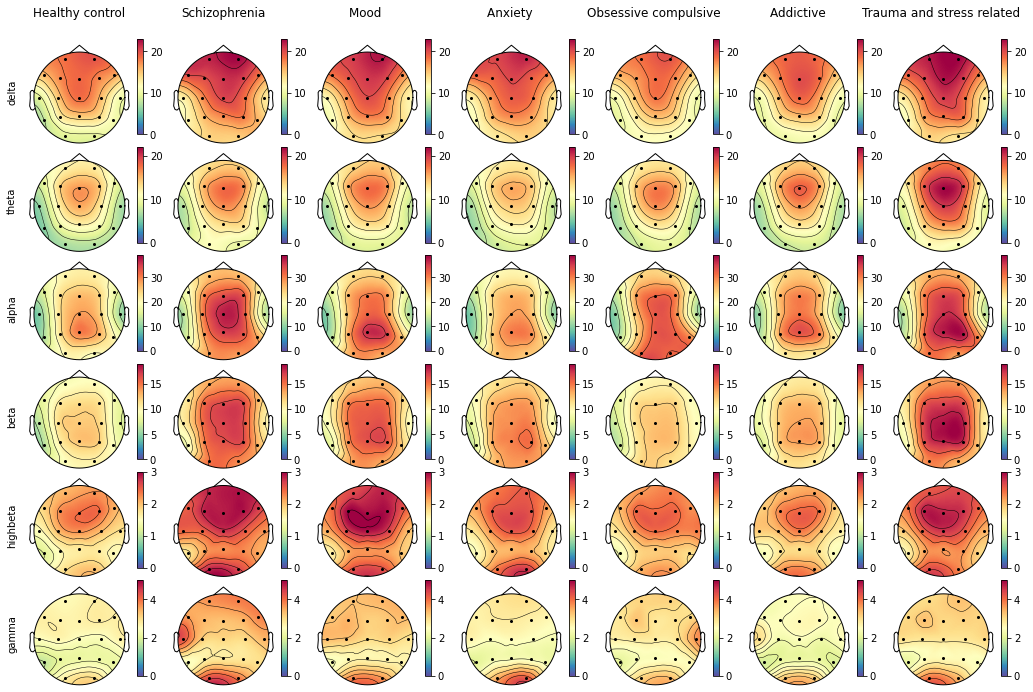

In [33]:
# order conditions (main.disorder)
conds = ['Healthy control',
         'Schizophrenia', 
         'Mood disorder', 
         'Anxiety disorder',  
         'Obsessive compulsive disorder', 
         'Addictive disorder',
         'Trauma and stress related disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(main_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()

### Specific disorders

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.canvas.print_figure(bytes_io, **kw)


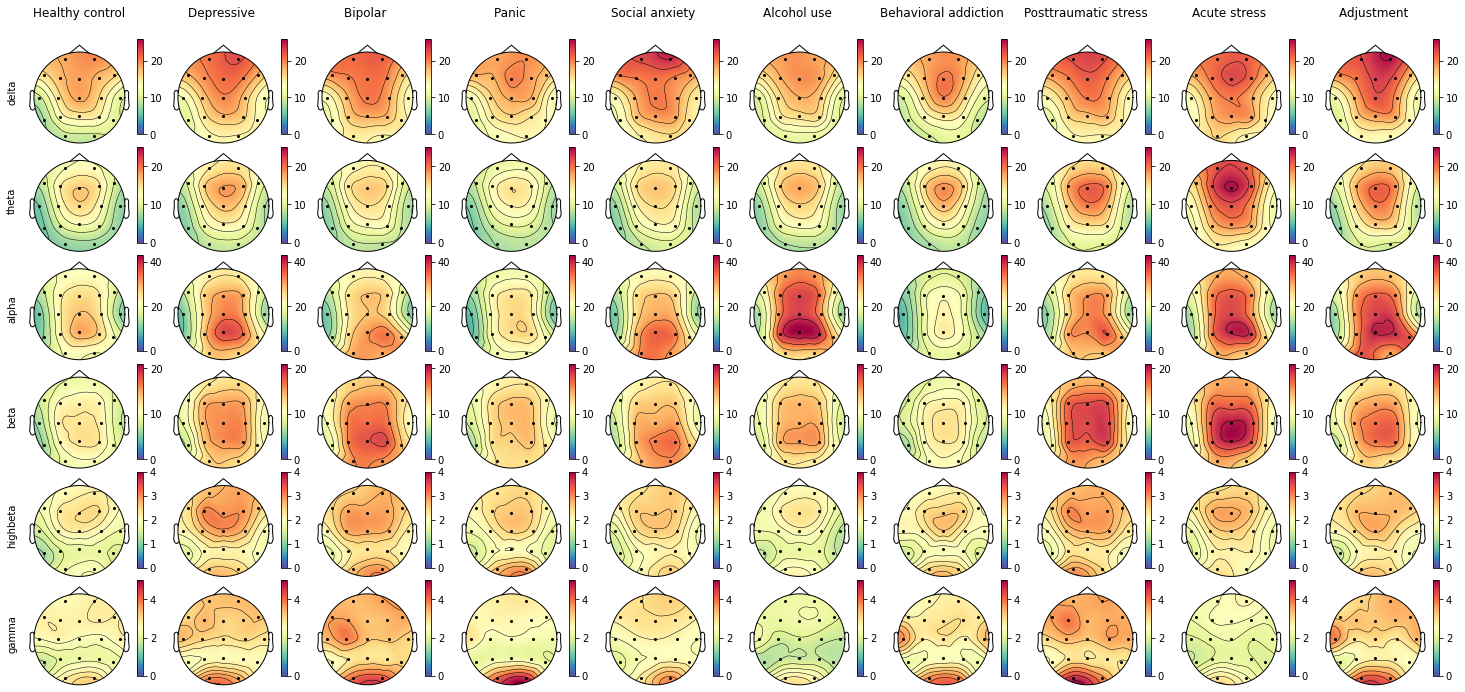

In [34]:
conds = ['Healthy control', 
         'Depressive disorder', 
         'Bipolar disorder',
         'Panic disorder',
         'Social anxiety disorder',
         'Alcohol use disorder',
         'Behavioral addiction disorder',
         'Posttraumatic stress disorder',
         'Acute stress disorder', 
         'Adjustment disorder']
conds_labs = [x.replace('disorder', '') for x in conds]
plot_eeg_dataset(spec_mean, channels, conditions_ordered=conds, condition_labels=conds_labs)
plt.show()